# Timescales vs. TSNR (HCP, Shine 1, Session 1, CleanGSR BNA)

In [1]:
# Parameters
dwi_data_label = "Yeh-HCP842"
results_dir = "/home/despo/dlurie/Projects/timescale_hierarchy/results"
resource_dir = "/home/despoB/dlurie/Projects/timescale_hierarchy/data/resources"
fmri_data_label = "HCP_Shine1_Session1_CleanGSR"
roi_subset = "CX"

In [2]:
import sys
import os
from glob import glob
from copy import copy
from scipy import stats
import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stat import S_IREAD, S_IRGRP, S_IROTH

/home/despoB/dlurie/anaconda3/envs/timescale/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/despoB/dlurie/anaconda3/envs/timescale/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
sys.path.append('/home/despo/dlurie/Projects/timescale_hierarchy/code/scripts/')
sys.path.append('/home/despo/dlurie/Projects/PyPALM/')

In [4]:
import pypalm as pm
import utils

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette("colorblind")
pal = copy(plt.cm.autumn_r)
pal.set_bad('lightgrey')

In [6]:
subject_list = np.genfromtxt('/home/despoB/dlurie/Projects/timescale_hierarchy/data/meta/subject_lists/HCP-Shine_1.txt', dtype="U")

In [7]:
tsnr_fpt = '/home/despo/dlurie/Projects/timescale_hierarchy/data/hcp/derivatives/sub-{0}_run-01_task-rest_acq-LR_bold_space-MNI_atlas-BNA_variant-preproc_tsnr.csv'

In [8]:
PPtsnr_store = []
mean_store = []
sd_store = []
for sub in subject_list:
    try:
        PPtsnr_file = tsnr_fpt.format(sub)
        PPtsnr_data = pd.read_csv(PPtsnr_file, index_col=0)
        mean_store.append(PPtsnr_data.tmean.values)
        PPtsnr_store.append(PPtsnr_data.tsnr.values)
        sd_store.append(PPtsnr_data.tsd.values)
    except:
        print("No data found for subject {0}".format(sub))
        pass
PPtsnr_store = np.array(PPtsnr_store)
mean_store = np.array(mean_store)
sd_store = np.array(sd_store)

In [9]:
ts_df = pd.read_csv(f'{results_dir}/timescales/{fmri_data_label}_BNA_timescale_df.csv')

In [10]:
roi_vols = np.genfromtxt(f'{resource_dir}/BNA-maxprob-thr25-2mm_ROI_volumes.txt')

In [11]:
df = pd.DataFrame([ts_df.lag1_median, roi_vols, np.median(mean_store, axis=0),
                   np.median(PPtsnr_store, axis=0), np.median(sd_store, axis=0)]).T
df.columns = ['lag1','roi_vols','tmean','PPtsnr', 'tsd']

In [12]:
df.iloc[:,2:].to_csv(f'{results_dir}/timescales/{fmri_data_label}_BNA_tSNR.tsv')

In [13]:
lag1_resid = smf.ols('lag1 ~ roi_vols', data=df).fit().resid + np.mean(df.lag1)
PPtsnr_resid = smf.ols('PPtsnr ~ roi_vols', data=df).fit().resid + np.mean(df.PPtsnr)
tmean_resid = smf.ols('tmean ~ roi_vols', data=df).fit().resid + np.mean(df.tmean)
sd_resid = smf.ols('tsd ~ roi_vols', data=df).fit().resid + np.mean(df.tsd)

In [14]:
df_resid = pd.DataFrame([lag1_resid, PPtsnr_resid, tmean_resid, sd_resid],
                       index=['Lag-1','tSNR','Mean', 'SD']).T

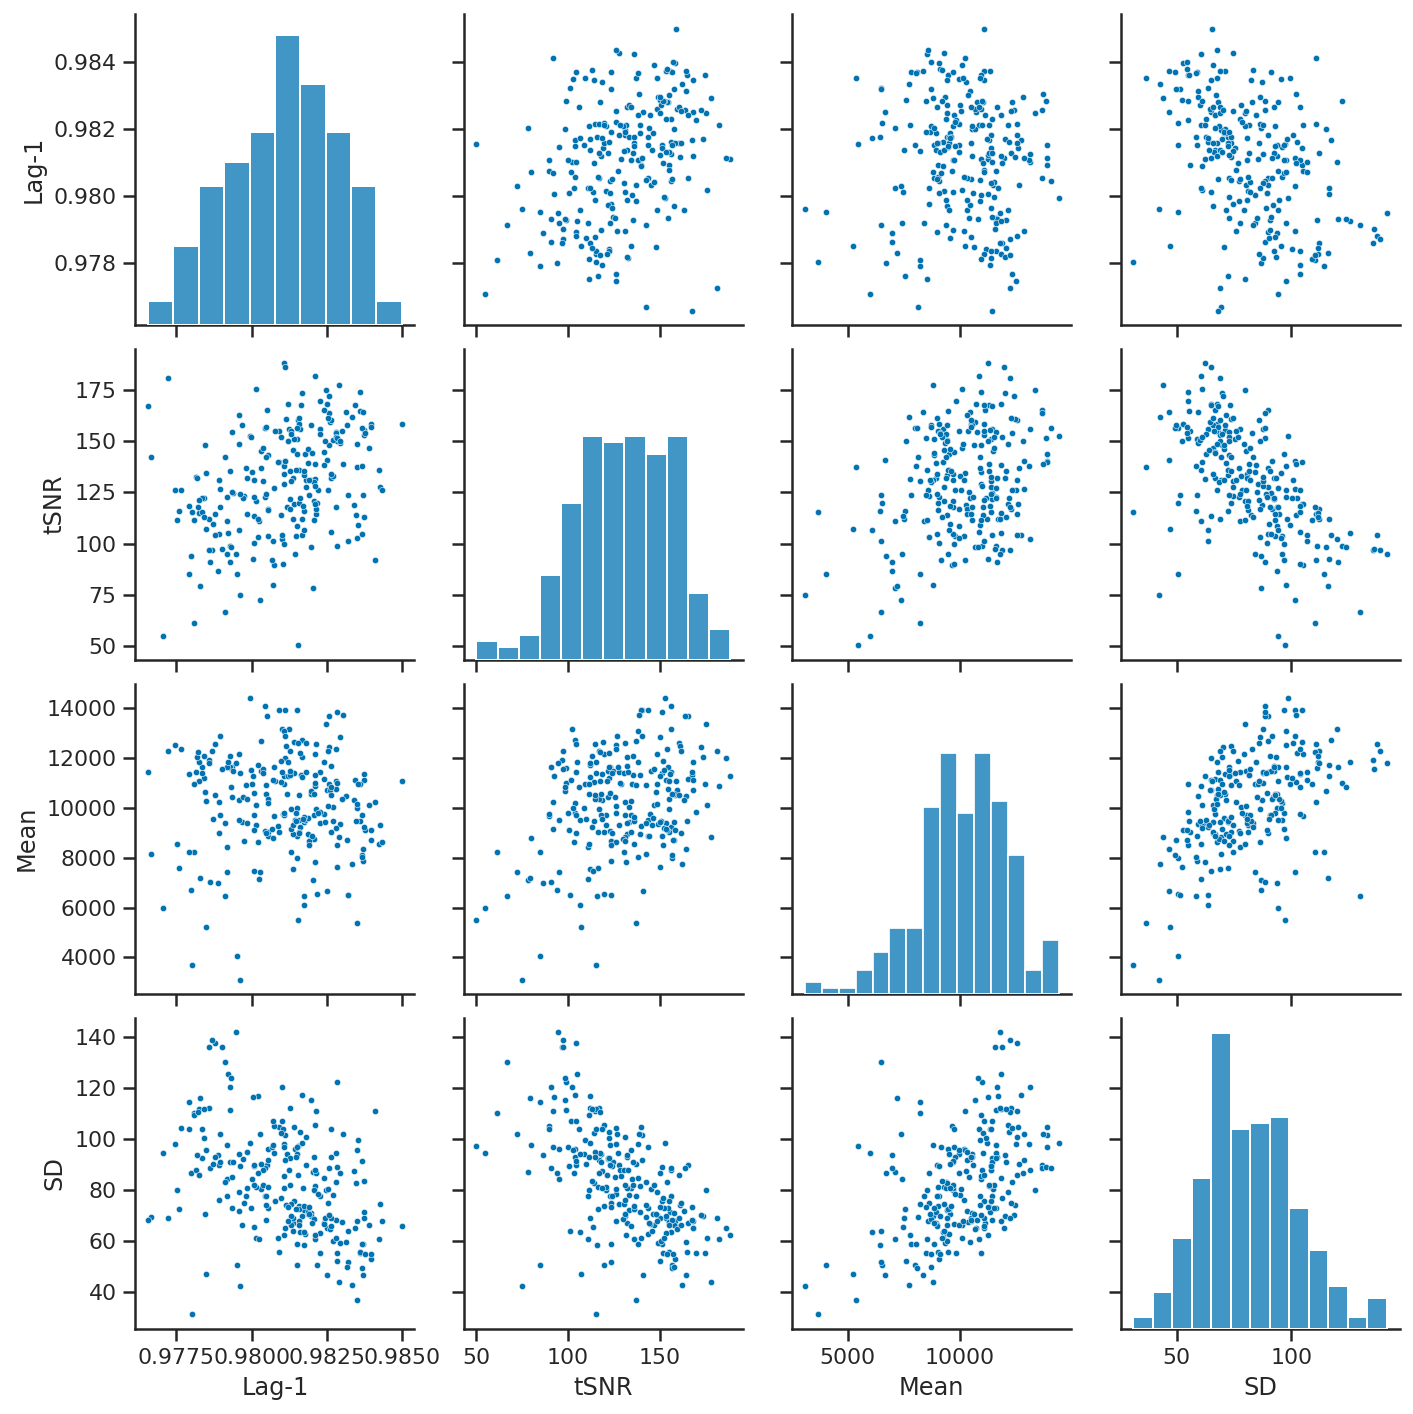

In [15]:
g = sns.pairplot(df_resid, plot_kws={'s':10})

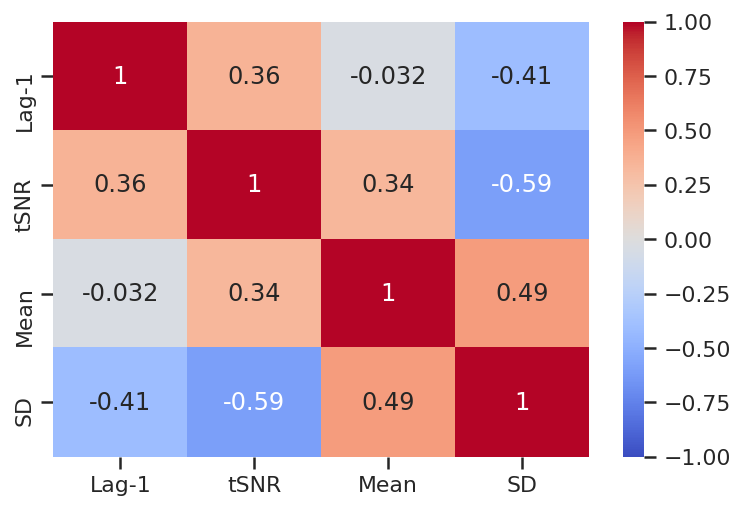

In [16]:
g = sns.heatmap(df_resid.corr(), annot=df_resid.corr(), cmap='coolwarm', vmin=-1, vmax=1)

### Compare lag-1 and basic signal properties between cortical and subcortical ROIS

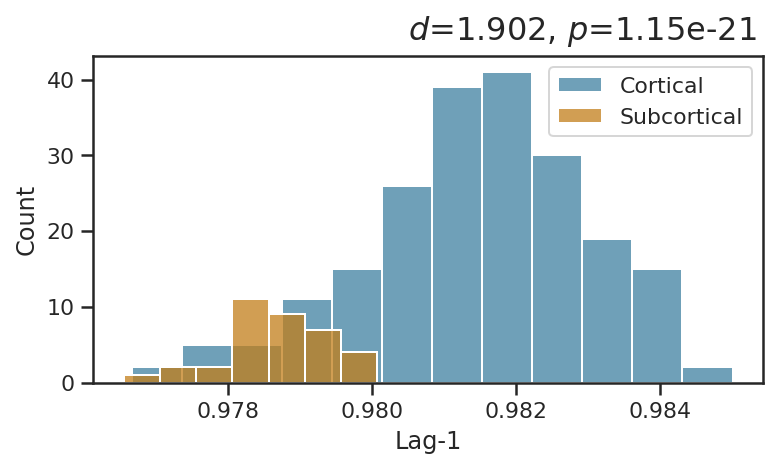

In [17]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,3))
sns.histplot(df_resid['Lag-1'][:210], color='#3F80A1', label='Cortical', ax=ax1)
sns.histplot(df_resid['Lag-1'][210:], color='#C27E19', label='Subcortical',ax=ax1)
plt.legend()
res = pg.ttest(df_resid['Lag-1'][:210], df_resid['Lag-1'][210:], correction='welch')
a = ax1.text(.99,1.05, "$\mathit{{d}}$={0:04.3f}, $\mathit{{p}}$={1:04.2e}".format(res['cohen-d'][0], res['p-val'][0]), 
            horizontalalignment='right', fontsize=16, transform=ax1.transAxes)

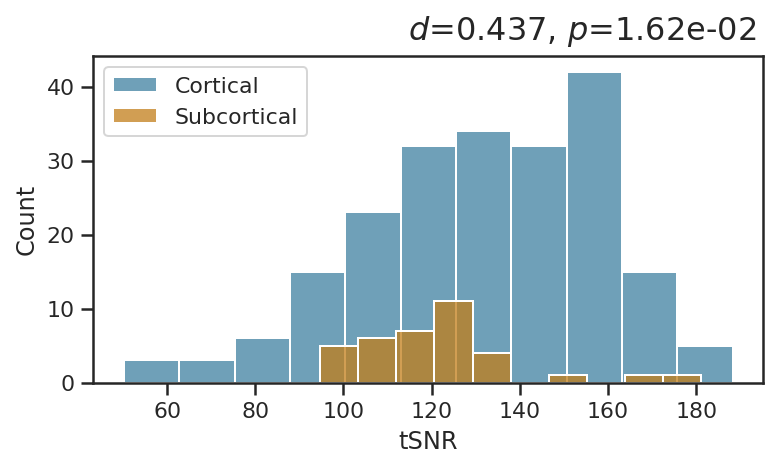

In [18]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,3))
sns.histplot(df_resid['tSNR'][:210], color='#3F80A1', label='Cortical', ax=ax1)
sns.histplot(df_resid['tSNR'][210:], color='#C27E19', label='Subcortical',ax=ax1)
plt.legend()
res = pg.ttest(df_resid['tSNR'][:210], df_resid['tSNR'][210:], correction='welch')
a = ax1.text(.99,1.05, "$\mathit{{d}}$={0:04.3f}, $\mathit{{p}}$={1:04.2e}".format(res['cohen-d'][0], res['p-val'][0]), 
            horizontalalignment='right', fontsize=16, transform=ax1.transAxes)

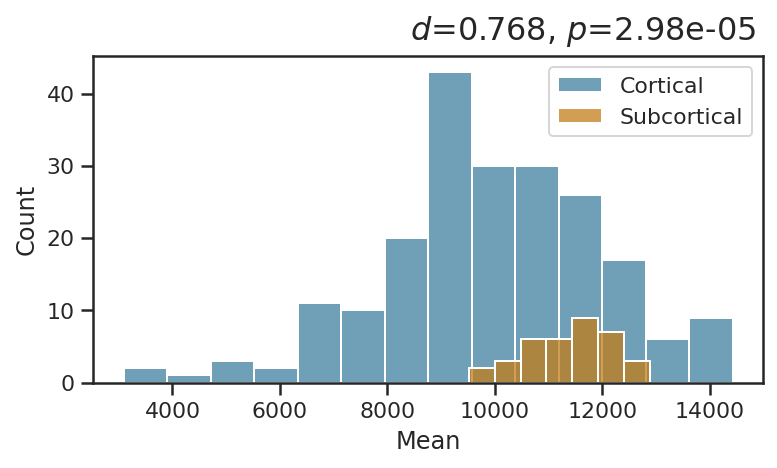

In [19]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,3))
sns.histplot(df_resid['Mean'][:210], color='#3F80A1', label='Cortical', ax=ax1)
sns.histplot(df_resid['Mean'][210:], color='#C27E19', label='Subcortical',ax=ax1)
plt.legend()
res = pg.ttest(df_resid['Mean'][:210], df_resid['Mean'][210:], correction='welch')
a = ax1.text(.99,1.05, "$\mathit{{d}}$={0:04.3f}, $\mathit{{p}}$={1:04.2e}".format(res['cohen-d'][0], res['p-val'][0]), 
            horizontalalignment='right', fontsize=16, transform=ax1.transAxes)

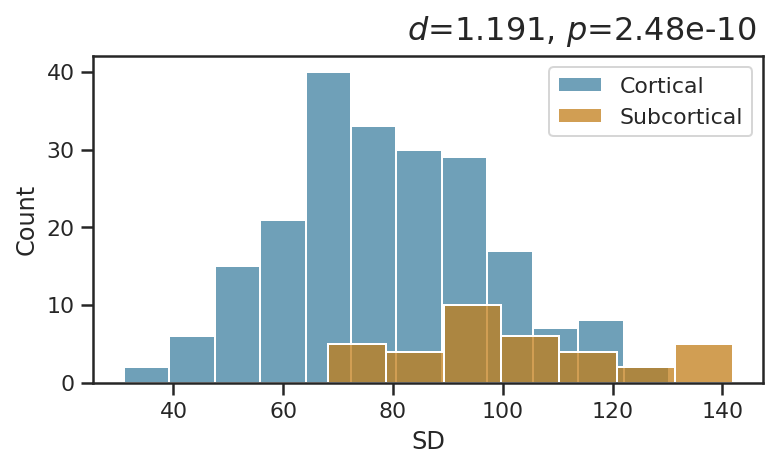

In [20]:
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6,3))
sns.histplot(df_resid['SD'][:210], color='#3F80A1', label='Cortical', ax=ax1)
sns.histplot(df_resid['SD'][210:], color='#C27E19', label='Subcortical',ax=ax1)
plt.legend()
res = pg.ttest(df_resid['SD'][:210], df_resid['SD'][210:], correction='welch')
a = ax1.text(.99,1.05, "$\mathit{{d}}$={0:04.3f}, $\mathit{{p}}$={1:04.2e}".format(res['cohen-d'][0], res['p-val'][0]), 
            horizontalalignment='right', fontsize=16, transform=ax1.transAxes)

## Test correlation between lag-1 and basic signal properties (cortical ROIs only)

In [21]:
lag1_vs_roiv_yhatperm = np.load(f'{results_dir}/stats/timescale_associations/{fmri_data_label}_BNA_{roi_subset}_Lag1_vs_ROIv_yhatperms.npy')

In [22]:
df_cx = df[:210]

#### tSNR

In [23]:
lag1_vs_pptsnr_rval, lag1_vs_pptsnr_pvals, lag1_vs_pptsnr_model, lag1_vs_pptsnr_rnull = pm.freedman_lane(df_cx, 'lag1', 'PPtsnr', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                             return_null=True, return_surrogates=False)

In [24]:
lag1_vs_pptsnr_rval

0.37413200270697117

In [25]:
lag1_vs_pptsnr_pvals

p_greater    0.027497
p_less       0.972603
p_abs        0.058294
dtype: float64

#### Mean

In [26]:
lag1_vs_mean_rval, lag1_vs_mean_pvals, lag1_vs_mean_model, lag1_vs_mean_rnull = pm.freedman_lane(df_cx, 'lag1', 'tmean', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                             return_null=True, return_surrogates=False)

In [27]:
lag1_vs_mean_rval

0.20353094755559734

In [28]:
lag1_vs_mean_pvals

p_greater    0.154985
p_less       0.845115
p_abs        0.316768
dtype: float64

#### SD

In [29]:
lag1_vs_SD_rval, lag1_vs_SD_pvals, lag1_vs_SD_model, lag1_vs_SD_rnull = pm.freedman_lane(df_cx, 'lag1', 'tsd', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm,
                                                                                             return_null=True, return_surrogates=False)

In [30]:
lag1_vs_SD_rval

-0.24958540104113447

In [31]:
lag1_vs_SD_pvals

p_greater    0.950105
p_less       0.049995
p_abs        0.102790
dtype: float64

## Exclude the 10% of cortical ROIs with the lowest tSNR

In [32]:
PPtsnr_T10 = df_cx.PPtsnr >= stats.scoreatpercentile(df_cx.PPtsnr, 10)

#### tSNR

In [33]:
E10_lag1_vs_pptsnr_rval, E10_lag1_vs_pptsnr_pvals, E10_lag1_vs_pptsnr_model, E10_lag1_vs_pptsnr_rnull = pm.freedman_lane(df_cx[PPtsnr_T10], 'lag1', 'PPtsnr', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm[:,PPtsnr_T10],
                                                                                             return_null=True, return_surrogates=False)

In [34]:
E10_lag1_vs_pptsnr_rval

0.11906733598276184

In [35]:
E10_lag1_vs_pptsnr_pvals

p_greater    0.265073
p_less       0.735026
p_abs        0.541246
dtype: float64

#### Mean

In [36]:
E10_lag1_vs_mean_rval, E10_lag1_vs_mean_pvals, E10_lag1_vs_mean_model, E10_lag1_vs_mean_rnull = pm.freedman_lane(df_cx[PPtsnr_T10], 'lag1', 'tmean', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm[:,PPtsnr_T10],
                                                                                             return_null=True, return_surrogates=False)

In [37]:
E10_lag1_vs_mean_rval

-0.03865154137987424

In [38]:
E10_lag1_vs_mean_pvals

p_greater    0.568343
p_less       0.431757
p_abs        0.861314
dtype: float64

#### SD

In [39]:
E10_lag1_vs_SD_rval, E10_lag1_vs_SD_pvals, E10_lag1_vs_SD_model, E10_lag1_vs_SD_rnull = pm.freedman_lane(df_cx[PPtsnr_T10], 'lag1', 'tsd', 'roi_vols',
                                                                                             stat='pcorr', n_perms=10000, perm_func=None,
                                                                                             perm_func_args=None, surrogates=lag1_vs_roiv_yhatperm[:,PPtsnr_T10],
                                                                                             return_null=True, return_surrogates=False)

In [40]:
E10_lag1_vs_SD_rval

-0.13338176470978444

In [41]:
E10_lag1_vs_SD_pvals

p_greater    0.796920
p_less       0.203180
p_abs        0.415658
dtype: float64